In [2]:
from mxnet import gluon
import mxnet as mx_net
import os
import numpy as np 
ctx = mx_net.cpu()
root_url = ('https://apache-mxnet.s3-accelerate.amazonaws.com/'
            'gluon/dataset/pikachu/')
data_dir = '../data/pikachu/'
dataset = {'train.rec': 'e6bcb6ffba1ac04ff8a9b1115e650af56ee969c8',
          'train.idx': 'dcf7318b2602c06428b9988470c731621716c393',
          'val.rec': 'd6c33f799b4d058e82f2cb5bd9a976f69d72d520'}
from mxnet import image
from mxnet import nd
shape_dataset = 256
date_batch_size = 32
mean_rgb_value = nd.array([123, 117, 104])
def iterators_get(shape_dataset, date_batch_size):
    NamesOfClass = ['pikachu'] #类名称
    NumOfClass = len(NamesOfClass)#类的个数
    Train_iterators = image.ImageDetIter(
        batch_size=date_batch_size,
        data_shape=(3, shape_dataset, shape_dataset),#3*256*256
        path_imgrec=data_dir+'train.rec',
        path_imgidx=data_dir+'train.idx',
        shuffle=True,
        mean=True,
        rand_crop=1,
        min_object_covered=0.95,
        max_attempts=200)
    Val_iterators = image.ImageDetIter(
        batch_size=date_batch_size,
        data_shape=(3, shape_dataset, shape_dataset),
        path_imgrec=data_dir+'val.rec',
        shuffle=False,
        mean=True)
    return Train_iterators, Val_iterators, NamesOfClass, NumOfClass

TrainData, TestData, NamesOfClass, NumOfClass = iterators_get(
    shape_dataset, date_batch_size)

batch_test = TrainData.next()
print(batch_test)
print((batch_test.data[0][0:1]).shape)


%matplotlib inline
import matplotlib as _plotlib
_plotlib.rcParams['figure.dpi']= 120
import matplotlib.pyplot as _pyplot

def RectBox(Box_Rectangle, color, linewidth=3):
    """convert an anchor Box_Rectangle to a matplotlib rectangle"""
    Box_Rectangle = Box_Rectangle.asnumpy()
    return _pyplot.Rectangle(
        (Box_Rectangle[0], Box_Rectangle[1]), Box_Rectangle[2]-Box_Rectangle[0], Box_Rectangle[3]-Box_Rectangle[1],
        fill=False, edgecolor=color, linewidth=linewidth)

from mxnet import nd
from mxnet.contrib.ndarray import MultiBoxPrior

#预测物体的类别
from mxnet.gluon import nn
def ClassPredictor(Anchors_Numbers, Classes_Numbers):
    """return a layer to predict classes"""
    return nn.Conv2D(Anchors_Numbers * (Classes_Numbers + 1), 3, padding=1)

#预测物体的边框
def YucheBox(Anchors_Numbers):
    """return a layer to predict delta locations"""
    return nn.Conv2D(Anchors_Numbers * 4, 3, padding=1)

#减半模块
def Reduce_Module(out_lays):
    """stack two Conv-BatchNorm-Relu blocks and then a pooling layer
    to halve the feature size"""
    outputs = nn.HybridSequential()
    for _ in range(2):
        outputs.add(nn.Conv2D(out_lays, 3, strides=1, padding=1))#输出　num_filters　个通道数
        outputs.add(nn.BatchNorm(in_channels=out_lays))#归一化
        outputs.add(nn.Activation('relu'))
    outputs.add(nn.MaxPool2D(2)) 
    return outputs

#将不同层的输出合并
def Fla_yuche(pred):
    return pred.transpose(axes=(0,2,3,1)).flatten()

def link_yuche(preds):
    return nd.concat(*preds, dim=1)

#主体网络
def main_body_net():
    outputs = nn.HybridSequential()
    for range_prediction in [16, 32, 64]:
        outputs.add(Reduce_Module(range_prediction))
    return outputs

#定义ssd模型
def SSD_Model(Anchors_Numbers, Classes_Numbers):
    ReduceSamplers = nn.Sequential()
    for _ in range(3):
        ReduceSamplers.add(Reduce_Module(128))
        
    ClassPred = nn.Sequential()
    Box_Pred = nn.Sequential()    
    for _ in range(5):
        ClassPred.add(ClassPredictor(Anchors_Numbers, Classes_Numbers))
        Box_Pred.add(YucheBox(Anchors_Numbers))

    All_Models = nn.Sequential()
    All_Models.add(main_body_net(), ReduceSamplers, ClassPred, Box_Pred)
    return All_Models

#计算预测

def SsdModelForward(x, All_Models, bbox_sizes, bbox_ratios, verbose=False):    
    main_body_net, ReduceSamplers, ClassPred, Box_Pred = All_Models
    output_anchors, output_class_preds, output_box_preds = [], [], []
    # feature extraction    
    x = main_body_net(x)#feature extraction完毕
    for i in range(5):
        # predict
        output_anchors.append(MultiBoxPrior(
            x, bbox_sizes=bbox_sizes[i], bbox_ratios=bbox_ratios[i]))
        output_class_preds.append(
            Fla_yuche(ClassPred[i](x)))
        output_box_preds.append(
            Fla_yuche(Box_Pred[i](x)))
        if verbose:
            print('Predict scale', i, x.shape, 'with', 
                  output_anchors[-1].shape[1], 'output_anchors')
        # down sample
        if i < 3:
            x = ReduceSamplers[i](x)
        elif i == 3:
            x = nd.Pooling(
                x, global_pool=True, pool_type='max', 
                kernel=(x.shape[2], x.shape[3]))
    # concat data
    return (link_yuche(output_anchors),
            link_yuche(output_class_preds),
            link_yuche(output_box_preds))

#完整的模型
from mxnet import gluon
class ToySSD(gluon.Block):
    def __init__(self, Classes_Numbers, verbose=False, **kwargs):
        super(ToySSD, self).__init__(**kwargs)
        # anchor Box_Rectangle bbox_sizes and bbox_ratios for 5 feature scales
        self.bbox_sizes = [[.2,.272], [.37,.447], [.54,.619], 
                      [.71,.79], [.88,.961]]
        self.bbox_ratios = [[1,2,.5]]*5
        self.Classes_Numbers = Classes_Numbers
        self.verbose = verbose
        Anchors_Numbers = len(self.bbox_sizes[0]) + len(self.bbox_ratios[0]) - 1
        # use name_scope to guard the names
        with self.name_scope():
            self.All_Models = SSD_Model(Anchors_Numbers, Classes_Numbers)

    def forward(self, x):
        output_anchors, output_class_preds, output_box_preds = SsdModelForward(
            x, self.All_Models, self.bbox_sizes, self.bbox_ratios, 
            verbose=self.verbose)
        # it is better to have class predictions reshaped for softmax computation       
        output_class_preds = output_class_preds.reshape(shape=(0, -1, self.Classes_Numbers+1))
        return output_anchors, output_class_preds, output_box_preds
    



/home/qy/software/anaconda3/envs/gluon/lib/python3.6/site-packages/mxnet/recordio.py:370: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  header = header._replace(label=np.fromstring(s, np.float32, header.flag))


DataBatch: data shapes: [(32, 3, 256, 256)] label shapes: [(32, 1, 5)]
(1, 3, 256, 256)


In [3]:
#预测初始化
from mxnet import init
from mxnet import cpu
import os
os.makedirs('checkpoints',exist_ok=True)
filename = "checkpoints/testnet.params"
filename_2 = "checkpoints_2/ssd_net.params"
filename_3 = "checkpoints_3/ssd_net_3.params"
ctx = cpu(0)
#TrainData.reshape(label_shape=(3, 5))
#TrainData = TestData.sync_label_shape(TrainData)
net = ToySSD(NumOfClass)
net.load_params(filename_3, ctx=ctx)



In [4]:
#图像预处理
def img_Processor(file_name):
    with open(file_name, 'rb') as f:
        img = image.imdecode(f.read())
    # resize to shape_dataset
    data = image.imresize(img, shape_dataset, shape_dataset)
    # minus rgb mean
    data = data.astype('float32') - mean_rgb_value
    # convert to batch_test x channel x height xwidth
    return data.transpose((2,0,1)).expand_dims(axis=0), img



In [5]:
#定义预测函数
from mxnet.contrib.ndarray import MultiBoxDetection

def predict(x):
    output_anchors, output_class_preds, output_box_preds = net(x.as_in_context(ctx))
    output_class_probs = nd.SoftmaxActivation(
        output_class_preds.transpose((0,2,1)), mode='channel')

    return MultiBoxDetection(output_class_probs, output_box_preds, output_anchors,force_suppress=True, clip=False)



In [6]:
#预测
path='../img/pikachu6_2.png'
path_2='../img/pikachu6.jpg'#经过旋转后的识别效果不如上图的好
path_3='../img/pikachu2.jpg'
x, img = img_Processor(path)
outputs = predict(x)
outputs.shape
print(outputs[0][0:20])



MXNetError: Cannot find argument 'bbox_ratios', Possible Arguments:
----------------
sizes : tuple of <float>, optional, default=[1]
    List of sizes of generated MultiBoxPriores.
ratios : tuple of <float>, optional, default=[1]
    List of aspect ratios of generated MultiBoxPriores.
clip : boolean, optional, default=0
    Whether to clip out-of-boundary boxes.
steps : tuple of <float>, optional, default=[-1,-1]
    Priorbox step across y and x, -1 for auto calculation.
offsets : tuple of <float>, optional, default=[0.5,0.5]
    Priorbox center offsets, y and x respectively
, in operator _contrib_MultiBoxPrior(name="", bbox_ratios="[1, 2, 0.5]", bbox_sizes="[0.2, 0.272]")

In [ ]:
#显示输出
five_colors = ['blue', 'green', 'red', 'black', 'magenta']
_plotlib.rcParams['figure.figsize'] = (6,6)

def display_preds(img, outputs, threshold=0.5):    
    _pyplot.imshow(img.asnumpy())
    for rows in outputs:
        rows = rows.asnumpy()
        class_num_id, class_score = int(rows[0]), rows[1]
        if class_num_id < 0 or class_score < threshold:
            continue
        color = five_colors[class_num_id%len(five_colors)]#例如０％５＝０　１％５＝１　２％５＝２
        Box_Rectangle = rows[2:6] * np.array([img.shape[0],img.shape[1]]*2)
        rect = RectBox(nd.array(Box_Rectangle), color, 2)
        _pyplot.gca().add_patch(rect)
                        
        text = NamesOfClass[class_num_id]
        _pyplot.gca().text(Box_Rectangle[0], Box_Rectangle[1], 
                       '{:s} {:.2f}'.format(text, class_score),
                       bbox=dict(facecolor=color, alpha=0.5),
                       fontsize=10, color='white')
    _pyplot.show()

display_preds(img, outputs[0], threshold=0.51)

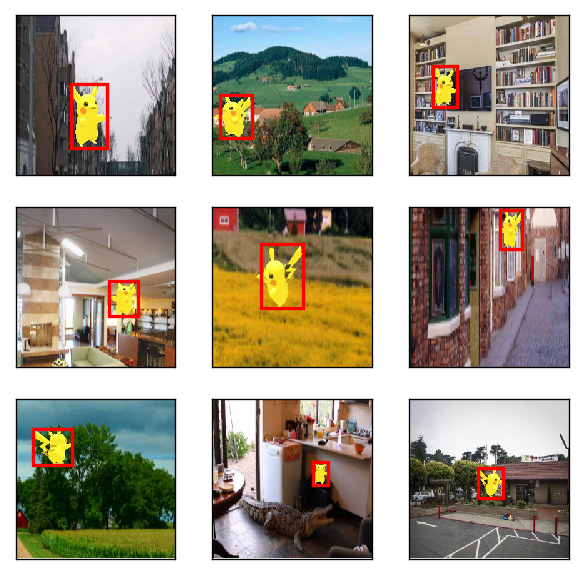

In [14]:
_, figs = _pyplot.subplots(3, 3, figsize=(6,6))
for i in range(3):
    for j in range(3):        
        img, labels = batch_test.data[0][3*i+j], batch_test.label[0][3*i+j]
        # (3L, 256L, 256L) => (256L, 256L, 3L)
        img = img.transpose((1, 2, 0)) + mean_rgb_value
        img = img.clip(0,255).asnumpy()/255
        fig = figs[i][j]
        fig.imshow(img)
        for label in labels:
            rect = RectBox(label[1:5]*shape_dataset,'red',2)
            fig.add_patch(rect)                    
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
_pyplot.show()